In [1]:
# Need to change to the same directory as project. Do not know why
import os
os.chdir("c:\\Users\\zhaobang\\OneDrive\\桌面\\NewKerosene")

from sktime.datasets import load_italy_power_demand
import pandas as pd
from sktime.distances import dtw_distance
import numpy as np
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
from modules.kerosenePreprocess import Kerosene
import modules.DataDrop as DD 
from tqdm import tqdm,trange
from modules.kerosenePreprocess import Kerosene


In [3]:
kerosene = Kerosene("../raw_data/2-supply-histories-with-sensor.csv")
# some special id to drop. Apporo dont need this
kerosene.normal_use.set_index("customer_id", inplace=True)
kerosene.normal_use.drop([666, 663, 650, 1086,725, 614, 775, 799, 1077], inplace=True)
kerosene.normal_use.reset_index(inplace=True)
for i in range(kerosene.normal_use.shape[0]):
    if kerosene.normal_use.loc[i, "volume"] == 0:
        kerosene.normal_use.drop(i, inplace=True)
kerosene.normal_use.reset_index(inplace=True)

normal_use_in_season = DD.supply_data_drop(kerosene.normal_use.copy())

df_weather = pd.read_csv("./raw_data/weather_data.csv")
df_weather = DD.weather_drop(df_weather)

ALL_ID = pd.unique(normal_use_in_season["customer_id"])

c:\Users\zhaobang\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [11]:
def calculate_cc(normal_use_in_season, ALL_ID, df_weather):
    
    # store every year correlation for every ID
    cc_id = []
    cc_id_year = []
    CC_ALL = {}
    CC_ALL_SEASON = {}

    # for each year
    weather_container_id_year = {}
    average_consumption_id_year = {}

    # for all data
    weather_container_id_all = {}
    average_consumption_id_all = []

    # temp variable
    weather_container_id = {}
    average_consumption = []

    # df_weather.reset_index(inplace = True)
    for id in ALL_ID:
        weather_container_id_year = {}
        average_consumption_id_year = {}
        # for all data
        weather_container_id_all = {}
        average_consumption_id_all = []
        
        # weather_container_id.update((x, -y) for x, y in weather_container_id.items())
        # df_weather.reset_index(inplace = True)
        df_id = normal_use_in_season[normal_use_in_season["customer_id"] == id]
        # remember to reset, because the index is the index in the last dataframe
        df_id.reset_index(inplace=True, drop=True)

        for j in range(df_id.shape[0] - 1):
            # check if the data is continuous
            if (df_id.loc[j + 1, "supplied_at"].year == df_id.loc[j, "supplied_at"].year and
                    df_id.loc[j + 1, "supplied_at"].month - df_id.loc[j, "supplied_at"].month > 6):
                if j == 0:
                    continue
                # store all the weather data for each year
                weather_container_id_year[str(df_id.loc[j + 1, "supplied_at"].year)] = weather_container_id
                # store all the consumption data for each year
                average_consumption_id_year[str(df_id.loc[j + 1, "supplied_at"].year)] = average_consumption
                # after store one year data, reset the temp variable to zero
                average_consumption = []
                weather_container_id = {}
                continue
            else:
                for i in range(df_weather.shape[0]):
                    if (df_weather.loc[i, "date"].year == df_id.loc[j, "supplied_at"].year and
                        df_weather.loc[i, "date"].month == df_id.loc[j, "supplied_at"].month and
                            df_weather.loc[i, "date"].day == df_id.loc[j, "supplied_at"].day):
                        
                        df_weather.set_index("date", inplace=True)
                        num_of_day = df_weather.sort_index().loc[df_id.loc[j, "supplied_at"]: df_id.loc[j + 1, "supplied_at"]].shape[0]
                        # reverse weather data for convenient
                        temp = -df_weather.sort_index().loc[df_id.loc[j, "supplied_at"]: df_id.loc[j + 1, "supplied_at"]]["average_tem"].mean()
                        # store number of days between two supplies
                        # calculate the mean value
                        average_consumption.append(df_id.loc[j + 1, "volume"] / num_of_day)
                        average_consumption_id_all.append(df_id.loc[j + 1, "volume"] / num_of_day)

                        weather_container_id[df_id.loc[j + 1, "supplied_at"]] = temp
                        weather_container_id_all[str(df_id.loc[j + 1, "supplied_at"].year) + "-" +
                                                 str(df_id.loc[j + 1, "supplied_at"].month) + "-" +
                                                 str(df_id.loc[j + 1, "supplied_at"].day)] = temp
                        # Time_all.append(df_id.loc[j + 1, "supplied_at"])
                        df_weather.reset_index(inplace=True)

                        # check if j is the last data,because we need j+1, j cannot be the last one.
                        if (j == (df_id.shape[0] - 2)):
                            weather_container_id_year[str(df_id.loc[j + 1, "supplied_at"].year)] = weather_container_id
                            average_consumption_id_year[str(df_id.loc[j + 1, "supplied_at"].year)] = average_consumption
                            weather_container_id = {}
                            average_consumption = []
                            break
                        else:
                            break
        for year in weather_container_id_year.keys():
            corr_oneY = np.corrcoef(average_consumption_id_year[year], list(weather_container_id_year[year].values()))[0][1]
            cc_id.append(corr_oneY)
            cc_id_year.append(year)
        CC_ALL[id] = cc_id
        CC_ALL_SEASON[id] = cc_id_year
        cc_id = []
        cc_id_year = []
    
    return CC_ALL, CC_ALL_SEASON

In [12]:
# Code to describe highcc_group
"""
highcc = pd.read_csv("./raw_data/weather_data.csv")

highcc_clusterdata, highcc_time_data = calculate_cc(highcc, higcc_ALL_ID, df_weather)
for i in higcc_ALL_ID:
    highcc_clusterdata[i] = pd.Series(highcc_clusterdata[i])
    highcc_time_data[i] = pd.Series(highcc_time_data[i])
highcc_cc_df =pd.DataFrame.from_dict(highcc_clusterdata)
highcc_cc_time_df = pd.DataFrame.from_dict(highcc_time_data)
def cc_describe(id_list, df_cc):
    s = pd.Series([])
    for i in id_list:
        s = pd.concat([s, df_cc[i]], ignore_index=True)
    return s
cc_describe(higcc_ALL_ID, highcc_cc_df).describe()
"""

c:\Users\zhaobang\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\lib\function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\zhaobang\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\Users\zhaobang\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [8]:
clusterdata, time_data = calculate_cc(normal_use_in_season, ALL_ID, df_weather)

In [13]:
ALL_ID = list(clusterdata.keys())

In [6]:
'''
for i in ALL_ID:
    if not np.all(np.isfinite(clusterdata[i])):
        print(i)
'''

'\nfor i in ALL_ID:\n    if not np.all(np.isfinite(clusterdata[i])):\n        print(i)\n'

In [7]:
for i in ALL_ID:
    clusterdata[i] = np.array(clusterdata[i])

In [8]:
n_series = len(clusterdata)
distance_matrix = np.zeros(shape=(n_series, n_series))

In [11]:
# Build distance matrix
for i in tqdm(range(n_series), desc='calculate distance matrix: '):
    for j in range(n_series):
        x = clusterdata[ALL_ID[i]]
        y = clusterdata[ALL_ID[j]]
        if i != j and distance_matrix[i, j] == 0:
            dist = dtw_distance(x, y)
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

calculate distance matrix: 100%|██████████| 116/116 [04:35<00:00,  2.38s/it]


c:\Users\zhaobang\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\cluster\hierarchy.py:364: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='complete', metric='euclidean')


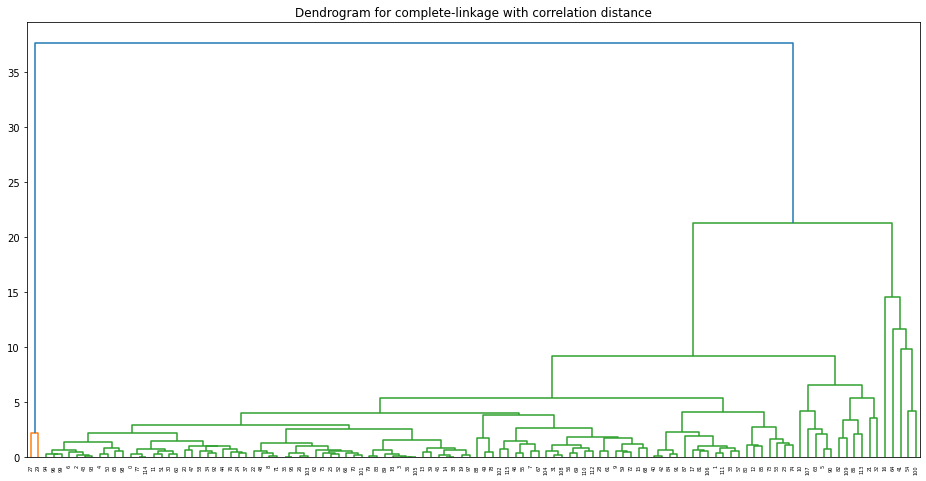

In [12]:
def hierarchical_clustering(dist_mat, method='complete'):
    if method == 'complete':
        Z = complete(distance_matrix)
    if method == 'single':
        Z = single(distance_matrix)
    if method == 'average':
        Z = average(distance_matrix)
    if method == 'ward':
        Z = ward(distance_matrix)
    
    fig = plt.figure(figsize=(16, 8))
    dn = dendrogram(Z)
    plt.title(f"Dendrogram for {method}-linkage with correlation distance")
    plt.show()
    
    return Z

linkage_matrix = hierarchical_clustering(distance_matrix)

In [13]:
from scipy.cluster.hierarchy import fcluster

# select maximum number of clusters
cluster_labels_3 = fcluster(linkage_matrix, 3, criterion='maxclust')
print(np.unique(cluster_labels_3))

# hand-select an appropriate cut-off on the dendrogram
cluster_labels_7 = fcluster(linkage_matrix, 5, criterion='distance')
print(np.unique(cluster_labels_7))
#>> 3 unique clusters
# cluster_labels_6 = fcluster(linkage_matrix, 2, criterion='distance')
# print(np.unique(cluster_labels_6))
#>> 2 unique clusters

[1 2 3]
[ 1  2  3  4  5  6  7  8  9 10]


In [14]:
df_cluster = {"ID": ALL_ID, "Cluster": cluster_labels_7}
df = pd.DataFrame(data=df_cluster)
df.to_csv("./ClusterData_cc/10_clusters.csv", index=False)

In [14]:
for i in ALL_ID:
    clusterdata[i] = pd.Series(clusterdata[i])

In [15]:
for i in ALL_ID:
    time_data[i] = pd.Series(time_data[i])

In [16]:
cc_df =pd.DataFrame.from_dict(clusterdata)
cc_time_df = pd.DataFrame.from_dict(time_data)

In [19]:
cc_df

,637,719,615,660,620,715,604,711,641,646,...,1092,1093,878,1095,881,867,1096,836,1097,879
0,0.895194,0.922165,0.955412,0.967092,0.954974,0.947831,0.944125,0.905033,0.847049,0.696594,...,0.979866,1.000000,0.751372,0.294892,0.771668,0.911177,0.749210,0.655636,0.916407,0.794681
1,0.966726,0.933242,0.978908,NaN,0.956921,0.509368,0.940564,0.957885,0.864942,0.960154,...,0.838250,0.620258,0.868746,0.933962,0.825703,0.855295,0.987289,0.388223,0.930367,0.752087
2,0.982455,0.673431,0.980974,NaN,0.911380,0.806954,0.937665,0.700313,NaN,NaN,...,0.824620,0.418739,0.820510,0.890274,0.763418,0.890526,0.911382,0.693400,0.985352,0.676965
3,NaN,0.854305,0.969252,NaN,0.963969,0.854366,0.943985,0.956228,NaN,NaN,...,0.971916,0.729126,0.952190,NaN,0.776350,0.719525,NaN,NaN,NaN,0.916057
4,NaN,0.892492,NaN,NaN,0.904611,0.313513,NaN,0.802124,NaN,NaN,...,0.878781,0.783885,0.855200,NaN,0.928999,0.931781,NaN,NaN,NaN,0.932340
5,NaN,0.849039,NaN,NaN,NaN,0.940136,NaN,0.893269,NaN,NaN,...,0.828203,0.699126,0.907767,NaN,NaN,0.844635,NaN,NaN,NaN,0.967825
6,NaN,0.916125,NaN,NaN,NaN,0.896836,NaN,0.963156,NaN,NaN,...,0.939601,0.643597,NaN,NaN,NaN,0.963166,NaN,NaN,NaN,NaN
7,NaN,0.914520,NaN,NaN,NaN,0.856152,NaN,NaN,NaN,NaN,...,0.808140,0.736492,NaN,NaN,NaN,0.910461,NaN,NaN,NaN,NaN
8,NaN,0.943883,NaN,NaN,NaN,0.960597,NaN,NaN,NaN,NaN,...,0.972064,0.517503,NaN,NaN,NaN,0.935447,NaN,NaN,NaN,NaN
9,NaN,0.889110,NaN,NaN,NaN,0.907878,NaN,NaN,NaN,NaN,...,0.939598,0.897729,NaN,NaN,NaN,0.942631,NaN,NaN,NaN,NaN


In [20]:
cc_time_df

,637,719,615,660,620,715,604,711,641,646,...,1092,1093,878,1095,881,867,1096,836,1097,879
0,2017,2010,2016,2019,2015,2010,2016,2013,2018,2018,...,2010,2010,2014,2017,2015,2010,2017,2017,2017,2014
1,2018,2011,2017,NaN,2016,2011,2017,2014,2019,2019,...,2011,2011,2015,2018,2016,2011,2018,2018,2018,2015
2,2019,2012,2018,NaN,2017,2012,2018,2015,NaN,NaN,...,2012,2012,2016,2019,2017,2012,2019,2019,2019,2016
3,NaN,2013,2019,NaN,2018,2013,2019,2016,NaN,NaN,...,2013,2013,2017,NaN,2018,2013,NaN,NaN,NaN,2017
4,NaN,2014,NaN,NaN,2019,2014,NaN,2017,NaN,NaN,...,2014,2014,2018,NaN,2019,2014,NaN,NaN,NaN,2018
5,NaN,2015,NaN,NaN,NaN,2015,NaN,2018,NaN,NaN,...,2015,2015,2019,NaN,NaN,2015,NaN,NaN,NaN,2019
6,NaN,2016,NaN,NaN,NaN,2016,NaN,2019,NaN,NaN,...,2016,2016,NaN,NaN,NaN,2016,NaN,NaN,NaN,NaN
7,NaN,2017,NaN,NaN,NaN,2017,NaN,NaN,NaN,NaN,...,2017,2017,NaN,NaN,NaN,2017,NaN,NaN,NaN,NaN
8,NaN,2018,NaN,NaN,NaN,2018,NaN,NaN,NaN,NaN,...,2018,2018,NaN,NaN,NaN,2018,NaN,NaN,NaN,NaN
9,NaN,2019,NaN,NaN,NaN,2019,NaN,NaN,NaN,NaN,...,2019,2019,NaN,NaN,NaN,2019,NaN,NaN,NaN,NaN


In [23]:
cc_df.to_csv("./ClusterData_cc/cc.csv", index=False)
cc_time_df.to_csv("./ClusterData_cc/cc_time.csv", index=False)